In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from random import random
import random
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
plt.ion()   # interactive mode

In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
size= 256
mean = (0.485, 0.456, 0.406)
std = (0.229,0.224, 0.225)
batch_size = 32

In [5]:
trainlists = pd.read_csv('./train_labels.csv')

npdatapath_list=np.array(trainlists)
trainlist, testlist = train_test_split(npdatapath_list, test_size = 0.2)

trainlists.head()

,path,target
0,train_1111.png,0
1,train_5746.png,0
2,train_6365.png,0
3,train_0152.png,1
4,train_0928.png,1


In [6]:
train_path =[]
temp = []
train_label = []
for i,f in enumerate(trainlist):
    temp.append(trainlist[i][0])
    train_label.append(trainlist[i][1])
    train_path.append('./input/train_images/'+temp[i])

test_path =[]
temp2 = []
test_label = []
for i,f in enumerate(testlist):
    temp2.append(testlist[i][0])
    test_label.append(testlist[i][1])
    test_path.append('./input/train_images/'+temp2[i])

In [7]:
def RandomErasing():
    '''
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    '''
    probability = 0.5                    #この処理を行う確率
    mean = [0.4914, 0.4822, 0.4465]      # RGBそれぞれの画素値（中間色）
    sl = 0.02                            #マスクする場合の最低の割合
    sh = 0.4                             #マスクする場合の最高の割合
    r1 = 0.3                             #マスクの縦横比

    if random.uniform(0, 1) > probability:  #乱数がprobability(0.5)を超えたら
        return img                          #画像をそのまま返す

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]   #画像サイズを取得
       
            target_area = random.uniform(sl, sh) * area  #面積を決定
            aspect_ratio = random.uniform(r1, 1/r1)      #縦横比を決定

            h = int(round(math.sqrt(target_area * aspect_ratio))) #マスクの高さを決定
            w = int(round(math.sqrt(target_area / aspect_ratio))) #マスクの幅を決定 #img.size() = [3,256,256]
            if w < img.size()[2] and h < img.size()[1]: #画像のサイズをマスクがオーバーしていないことを確認
                x1 = random.randint(0, img.size()[1] - h)     #左上のx座標を決定
                y1 = random.randint(0, img.size()[2] - w)     #左上のy座標を決定
                if img.size()[0] == 3:                  #3チャンネル画像の場合
                    img[0, x1:x1+h, y1:y1+w] = mean[0]  #色で埋める
                    img[1, x1:x1+h, y1:y1+w] = mean[1]
                    img[2, x1:x1+h, y1:y1+w] = mean[2]
                else:                                   #グレースケール画像の場合
                    img[0, x1:x1+h, y1:y1+w] = mean[0]
            
                return img
      
    

In [8]:
def random_erasing(img, p=0.5, sl=0.02, sh=0.4, r1=0.3, r2=3.3):
    target_img = img.copy()

    if p < random.uniform(0, 1):
        return target_img 

    H, W, _ = target_img.shape
    S = H * W

    while True:
        Se = np.random.uniform(sl, sh) * S # 画像に重畳する矩形の面積
        re = np.random.uniform(r1, r2) # 画像に重畳する矩形のアスペクト比

        He = int(np.sqrt(Se * re)) # 画像に重畳する矩形のHeight
        We = int(np.sqrt(Se / re)) # 画像に重畳する矩形のWidth

        xe = np.random.randint(0, W) # 画像に重畳する矩形のx座標
        ye = np.random.randint(0, H) # 画像に重畳する矩形のy座標

        if xe + We <= W and ye + He <= H:
            # 画像に重畳する矩形が画像からはみ出していなければbreak
            break

    mask = np.random.randint(0, 255, (He, We, 3)) # 矩形がを生成 矩形内の値はランダム値
    target_img[ye:ye + He, xe:xe + We, :] = mask # 画像に矩形を重畳

    return target_img

In [14]:
class ImageTransform():
    """
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation((180,180)),# データオーギュメンテーション
                transforms.ToTensor(),# テンソルに変換
                transforms.Normalize(mean, std),
                #transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [15]:
class yeardetectDataset(torch.utils.data.Dataset):


    def __init__(self, transform=None, phase='train'):
        #self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        if self.phase == 'train':
            return len(train_path)
        if self.phase == 'val':
            return len(test_path)
        #return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''
        if self.phase == 'train':
            img_path = train_path[index]
            img = Image.open(img_path)
        elif self.phase =='val':
            img_path = test_path[index]
            img = Image.open(img_path)
        # index番目の画像をロード
        #img_path = self.file_list[index]
        #img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベル取得
        if self.phase == "train":
            label = train_label[index]
        elif self.phase == "val":
            label = test_label[index]
  
        
        

        return img_transformed, label
    
train_dataset = yeardetectDataset(
    transform=ImageTransform(size, mean, std), phase='train')

val_dataset = yeardetectDataset(
     transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 80
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 256, 256])
23


In [16]:
# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator) 
# 1番目の要素を取り出す
print(inputs.size())
print(labels.size())


torch.Size([32, 3, 256, 256])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


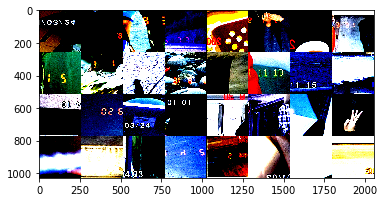

In [17]:
import matplotlib.pyplot as plt
img = torchvision.utils.make_grid(inputs,nrow=8, padding=1)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.show()

In [18]:
nfd = 128

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, nfd//8 , 3 , 1 , 1 ,bias=False),
            
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nfd//8, nfd//4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd//4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//4, nfd//4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd//4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//4, nfd//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//2, nfd//2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd//2, nfd, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd, nfd, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(nfd, nfd*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nfd*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(nfd*2, nfd*2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(nfd*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.2),
            
            Flatten(),
            
            nn.Linear(nfd*nfd*nfd//32,40)
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [19]:
from torchsummary import summary
net = DNet().to('cuda')
summary(net, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             432
         LeakyReLU-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 32, 128, 128]           8,192
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         LeakyReLU-5         [-1, 32, 128, 128]               0
         Dropout2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           9,216
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         LeakyReLU-9         [-1, 32, 128, 128]               0
        Dropout2d-10         [-1, 32, 128, 128]               0
           Conv2d-11           [-1, 64, 64, 64]          32,768
      BatchNorm2d-12           [-1, 64, 64, 64]             128
        LeakyReLU-13           [-1, 64, 64, 64]               0
        Dropout2d-14           [-1, 64,

resnet

import torchvision.models as models
net = models.resnet18(pretrained=True)
# すべてのパラメータを固定
for param in net.parameters():
    param.requires_grad = False

# 最後のfc層を置き換える
# これはデフォルトの requires_grad=True のままなのでパラメータ更新対象
net.fc = nn.Linear(in_features = 512, out_features = 40, bias=True)
net.to('cuda')

In [20]:
#損失関数の決定
criterion = nn.CrossEntropyLoss()
# 最適化手法の設定
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(),lr=0.002, betas=(0.5, 0.999))

In [21]:
def original_criterion(outputs, labels):
    criterion = nn.CrossEntropyLoss()

    loss = 0

    # 正解との誤差
    loss += 0.9 * criterion(outputs, labels)

    # "正解 - 1"との誤差
    loss += 0.05 * criterion(torch.roll(outputs,-1), labels)

    # "正解 + 1"との誤差
    loss += 0.05 * criterion(torch.roll(outputs, 1), labels)
    return loss

In [22]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                inputs = inputs.to('cuda')
                labels = labels.long().to('cuda')
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = original_criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)

                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.long().data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
                
            if phase =='val':
                if epoch > 1 and epoch_loss < val_loss_list[-1]:
                    save_path = './saved_prm/weights_fujifilm_randomerase_2,6,2'+str(epoch)+'.pth'
                    best_param = copy.deepcopy(net.state_dict())
                    torch.save(best_param,save_path)   
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
                

    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [23]:
num_epochs=600
net.train()
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/600
-------------


100%|██████████| 42/42 [00:06<00:00,  6.46it/s]


val Loss: 3.6891 Acc: 0.0082
Epoch 2/600
-------------


100%|██████████| 168/168 [00:45<00:00,  3.67it/s]


train Loss: 22.9080 Acc: 0.0318


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 34.5904 Acc: 0.0374
Epoch 3/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 11.5294 Acc: 0.0396


100%|██████████| 42/42 [00:05<00:00,  7.34it/s]


val Loss: 6.1717 Acc: 0.0344
Epoch 4/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.02it/s]


train Loss: 8.5510 Acc: 0.0441


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 7.6830 Acc: 0.0419
Epoch 5/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 8.1178 Acc: 0.0428


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 29.9810 Acc: 0.0553
Epoch 6/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 7.2030 Acc: 0.0421


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 6.0854 Acc: 0.0389
Epoch 7/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.09it/s]


train Loss: 6.6949 Acc: 0.0522


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 13.9171 Acc: 0.0568
Epoch 8/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 6.0093 Acc: 0.0497


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 6.0410 Acc: 0.0620
Epoch 9/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 5.6852 Acc: 0.0490


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 4.2869 Acc: 0.0389
Epoch 10/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.09it/s]


train Loss: 4.8963 Acc: 0.0469


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 4.5055 Acc: 0.0389
Epoch 11/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 4.6387 Acc: 0.0486


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 4.1247 Acc: 0.0568
Epoch 12/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 4.2675 Acc: 0.0563


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 5.1821 Acc: 0.0658
Epoch 13/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.9955 Acc: 0.0565


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 3.9699 Acc: 0.0605
Epoch 14/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.8247 Acc: 0.0561


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 3.6879 Acc: 0.0710
Epoch 15/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.6703 Acc: 0.0647


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 3.4851 Acc: 0.0635
Epoch 16/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.5893 Acc: 0.0707


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 3.5211 Acc: 0.0583
Epoch 17/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.97it/s]


train Loss: 3.5416 Acc: 0.0658


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 3.4974 Acc: 0.0755
Epoch 18/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.5022 Acc: 0.0666


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 3.5411 Acc: 0.0673
Epoch 19/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.4788 Acc: 0.0699


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 3.5129 Acc: 0.0859
Epoch 20/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.4645 Acc: 0.0767


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 3.4363 Acc: 0.0859
Epoch 21/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.4629 Acc: 0.0729


100%|██████████| 42/42 [00:05<00:00,  7.39it/s]


val Loss: 3.4198 Acc: 0.0897
Epoch 22/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.4613 Acc: 0.0787


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 3.4503 Acc: 0.0815
Epoch 23/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.4601 Acc: 0.0742


100%|██████████| 42/42 [00:05<00:00,  7.37it/s]


val Loss: 3.4212 Acc: 0.0658
Epoch 24/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.4504 Acc: 0.0769


100%|██████████| 42/42 [00:05<00:00,  7.39it/s]


val Loss: 3.4288 Acc: 0.0777
Epoch 25/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.4483 Acc: 0.0763


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 3.4057 Acc: 0.0800
Epoch 26/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.4401 Acc: 0.0746


100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


val Loss: 3.4077 Acc: 0.0785
Epoch 27/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.4461 Acc: 0.0780


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 3.4205 Acc: 0.0800
Epoch 28/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.4356 Acc: 0.0797


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.4322 Acc: 0.0800
Epoch 29/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.4338 Acc: 0.0815


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 3.4559 Acc: 0.0561
Epoch 30/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.4216 Acc: 0.0843


100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


val Loss: 3.3973 Acc: 0.0688
Epoch 31/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.4127 Acc: 0.0841


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 3.3534 Acc: 0.1024
Epoch 32/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.3887 Acc: 0.0905


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.4671 Acc: 0.0620
Epoch 33/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3828 Acc: 0.0914


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 3.3871 Acc: 0.0979
Epoch 34/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3667 Acc: 0.0916


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 3.3890 Acc: 0.0792
Epoch 35/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.3658 Acc: 0.0884


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


val Loss: 3.2976 Acc: 0.1151
Epoch 36/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3391 Acc: 0.0935


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 3.8992 Acc: 0.0688
Epoch 37/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3464 Acc: 0.0965


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 3.2948 Acc: 0.1016
Epoch 38/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3389 Acc: 0.0970


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 3.3483 Acc: 0.1121
Epoch 39/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3311 Acc: 0.1006


100%|██████████| 42/42 [00:05<00:00,  7.37it/s]


val Loss: 3.3773 Acc: 0.1024
Epoch 40/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.3172 Acc: 0.1000


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 3.3319 Acc: 0.1091
Epoch 41/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3138 Acc: 0.1036


100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


val Loss: 3.4206 Acc: 0.0852
Epoch 42/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.3161 Acc: 0.1034


100%|██████████| 42/42 [00:05<00:00,  7.38it/s]


val Loss: 3.5111 Acc: 0.1009
Epoch 43/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3167 Acc: 0.1045


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 3.2826 Acc: 0.1241
Epoch 44/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2982 Acc: 0.0980


100%|██████████| 42/42 [00:05<00:00,  7.32it/s]


val Loss: 3.2189 Acc: 0.1353
Epoch 45/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2991 Acc: 0.1083


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 3.3697 Acc: 0.0732
Epoch 46/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.3007 Acc: 0.0995


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 3.2793 Acc: 0.0785
Epoch 47/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.3033 Acc: 0.0978


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 3.2779 Acc: 0.1263
Epoch 48/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2930 Acc: 0.1049


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 3.2415 Acc: 0.1211
Epoch 49/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2635 Acc: 0.1081


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.2532 Acc: 0.1024
Epoch 50/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2759 Acc: 0.1085


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 3.3063 Acc: 0.1069
Epoch 51/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2721 Acc: 0.1083


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 3.3132 Acc: 0.1076
Epoch 52/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2800 Acc: 0.1073


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 3.2722 Acc: 0.1345
Epoch 53/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2599 Acc: 0.1043


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 3.3424 Acc: 0.1016
Epoch 54/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2819 Acc: 0.1060


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 3.3306 Acc: 0.1009
Epoch 55/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2729 Acc: 0.1113


100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


val Loss: 3.3302 Acc: 0.1076
Epoch 56/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.2733 Acc: 0.1077


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 3.2123 Acc: 0.1114
Epoch 57/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.08it/s]


train Loss: 3.2807 Acc: 0.0942


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 3.2233 Acc: 0.1203
Epoch 58/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2649 Acc: 0.1141


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 3.4284 Acc: 0.0972
Epoch 59/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2529 Acc: 0.1105


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 3.1333 Acc: 0.1472
Epoch 60/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2628 Acc: 0.1111


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 3.2118 Acc: 0.1166
Epoch 61/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.2549 Acc: 0.1142


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 3.2359 Acc: 0.1151
Epoch 62/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2577 Acc: 0.1092


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 3.4173 Acc: 0.0994
Epoch 63/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2583 Acc: 0.1126


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 3.3332 Acc: 0.1054
Epoch 64/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2446 Acc: 0.1126


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 3.2394 Acc: 0.1166
Epoch 65/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2426 Acc: 0.1180


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.2307 Acc: 0.1158
Epoch 66/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2398 Acc: 0.1212


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 3.3817 Acc: 0.1084
Epoch 67/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2264 Acc: 0.1163


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.1329 Acc: 0.1442
Epoch 68/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2196 Acc: 0.1165


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.2170 Acc: 0.1129
Epoch 69/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.2213 Acc: 0.1195


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 3.3380 Acc: 0.1129
Epoch 70/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2269 Acc: 0.1228


100%|██████████| 42/42 [00:05<00:00,  7.38it/s]


val Loss: 3.5064 Acc: 0.0949
Epoch 71/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.2205 Acc: 0.1208


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 3.1731 Acc: 0.1256
Epoch 72/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.2170 Acc: 0.1204


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 3.2931 Acc: 0.1106
Epoch 73/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2193 Acc: 0.1236


100%|██████████| 42/42 [00:05<00:00,  7.37it/s]


val Loss: 3.1197 Acc: 0.1368
Epoch 74/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2244 Acc: 0.1195


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 7.8920 Acc: 0.0568
Epoch 75/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2448 Acc: 0.1144


100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


val Loss: 3.1634 Acc: 0.1659
Epoch 76/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2017 Acc: 0.1268


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.1981 Acc: 0.1300
Epoch 77/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.04it/s]


train Loss: 3.1988 Acc: 0.1264


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 3.1385 Acc: 0.1487
Epoch 78/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.2018 Acc: 0.1178


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 3.2429 Acc: 0.1016
Epoch 79/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.2051 Acc: 0.1262


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 3.2409 Acc: 0.1338
Epoch 80/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.1834 Acc: 0.1264


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 3.3243 Acc: 0.1495
Epoch 81/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.1988 Acc: 0.1283


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 3.2365 Acc: 0.1383
Epoch 82/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.2038 Acc: 0.1260


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 3.0895 Acc: 0.1487
Epoch 83/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.1787 Acc: 0.1315


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.2012 Acc: 0.1353
Epoch 84/600
-------------


100%|██████████| 168/168 [00:42<00:00,  4.00it/s]


train Loss: 3.1861 Acc: 0.1270


100%|██████████| 42/42 [00:05<00:00,  7.37it/s]


val Loss: 3.2364 Acc: 0.1226
Epoch 85/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1839 Acc: 0.1240


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 3.2397 Acc: 0.1413
Epoch 86/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1627 Acc: 0.1329


100%|██████████| 42/42 [00:05<00:00,  7.39it/s]


val Loss: 3.4730 Acc: 0.0912
Epoch 87/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.1942 Acc: 0.1245


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 3.2361 Acc: 0.1405
Epoch 88/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1582 Acc: 0.1346


100%|██████████| 42/42 [00:05<00:00,  7.32it/s]


val Loss: 3.1947 Acc: 0.1525
Epoch 89/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1933 Acc: 0.1242


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 3.1362 Acc: 0.1383
Epoch 90/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1701 Acc: 0.1315


100%|██████████| 42/42 [00:05<00:00,  7.37it/s]


val Loss: 3.1213 Acc: 0.1502
Epoch 91/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1551 Acc: 0.1386


100%|██████████| 42/42 [00:05<00:00,  7.31it/s]


val Loss: 3.2339 Acc: 0.1450
Epoch 92/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1548 Acc: 0.1344


100%|██████████| 42/42 [00:05<00:00,  7.33it/s]


val Loss: 3.2699 Acc: 0.1203
Epoch 93/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.1446 Acc: 0.1395


100%|██████████| 42/42 [00:05<00:00,  7.34it/s]


val Loss: 3.1860 Acc: 0.1054
Epoch 94/600
-------------


100%|██████████| 168/168 [00:43<00:00,  3.88it/s]


train Loss: 3.1394 Acc: 0.1365


100%|██████████| 42/42 [00:05<00:00,  7.34it/s]


val Loss: 3.0456 Acc: 0.1682
Epoch 95/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 3.1341 Acc: 0.1391


100%|██████████| 42/42 [00:05<00:00,  7.34it/s]


val Loss: 3.1061 Acc: 0.1442
Epoch 96/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1347 Acc: 0.1359


100%|██████████| 42/42 [00:05<00:00,  7.32it/s]


val Loss: 3.0123 Acc: 0.1637
Epoch 97/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1346 Acc: 0.1444


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 3.1698 Acc: 0.1457
Epoch 98/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 3.1191 Acc: 0.1404


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 3.0331 Acc: 0.1532
Epoch 99/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1195 Acc: 0.1402


100%|██████████| 42/42 [00:05<00:00,  7.32it/s]


val Loss: 3.0524 Acc: 0.1652
Epoch 100/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1308 Acc: 0.1419


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 3.0871 Acc: 0.1263
Epoch 101/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1236 Acc: 0.1427


100%|██████████| 42/42 [00:05<00:00,  7.29it/s]


val Loss: 2.9817 Acc: 0.1712
Epoch 102/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1071 Acc: 0.1429


100%|██████████| 42/42 [00:05<00:00,  7.37it/s]


val Loss: 3.1503 Acc: 0.1353
Epoch 103/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.1321 Acc: 0.1333


100%|██████████| 42/42 [00:05<00:00,  7.39it/s]


val Loss: 3.0350 Acc: 0.1749
Epoch 104/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1069 Acc: 0.1460


100%|██████████| 42/42 [00:05<00:00,  7.32it/s]


val Loss: 3.0261 Acc: 0.1697
Epoch 105/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.1128 Acc: 0.1444


100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


val Loss: 3.0488 Acc: 0.1741
Epoch 106/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.0920 Acc: 0.1509


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 3.0014 Acc: 0.1816
Epoch 107/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0849 Acc: 0.1522


100%|██████████| 42/42 [00:05<00:00,  7.33it/s]


val Loss: 3.0656 Acc: 0.1360
Epoch 108/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.0835 Acc: 0.1453


100%|██████████| 42/42 [00:05<00:00,  7.38it/s]


val Loss: 3.0826 Acc: 0.1547
Epoch 109/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0931 Acc: 0.1442


100%|██████████| 42/42 [00:05<00:00,  7.34it/s]


val Loss: 3.0449 Acc: 0.1390
Epoch 110/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.0676 Acc: 0.1561


100%|██████████| 42/42 [00:05<00:00,  7.28it/s]


val Loss: 2.9805 Acc: 0.1540
Epoch 111/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.97it/s]


train Loss: 3.0882 Acc: 0.1457


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 2.9656 Acc: 0.1525
Epoch 112/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0820 Acc: 0.1487


100%|██████████| 42/42 [00:05<00:00,  7.28it/s]


val Loss: 3.0134 Acc: 0.1749
Epoch 113/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0794 Acc: 0.1453


100%|██████████| 42/42 [00:05<00:00,  7.26it/s]


val Loss: 3.0673 Acc: 0.1614
Epoch 114/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.0639 Acc: 0.1468


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 2.9422 Acc: 0.1457
Epoch 115/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.97it/s]


train Loss: 3.0728 Acc: 0.1602


100%|██████████| 42/42 [00:05<00:00,  7.28it/s]


val Loss: 3.0562 Acc: 0.1659
Epoch 116/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0845 Acc: 0.1488


100%|██████████| 42/42 [00:05<00:00,  7.20it/s]


val Loss: 2.9961 Acc: 0.1674
Epoch 117/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0504 Acc: 0.1501


100%|██████████| 42/42 [00:05<00:00,  7.31it/s]


val Loss: 2.9953 Acc: 0.1809
Epoch 118/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.0524 Acc: 0.1509


100%|██████████| 42/42 [00:05<00:00,  7.26it/s]


val Loss: 3.0043 Acc: 0.1667
Epoch 119/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0372 Acc: 0.1614


100%|██████████| 42/42 [00:05<00:00,  7.29it/s]


val Loss: 2.9385 Acc: 0.1898
Epoch 120/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 3.0526 Acc: 0.1530


100%|██████████| 42/42 [00:05<00:00,  7.32it/s]


val Loss: 3.0841 Acc: 0.1764
Epoch 121/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 3.0497 Acc: 0.1571


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 2.8917 Acc: 0.1854
Epoch 122/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0346 Acc: 0.1578


100%|██████████| 42/42 [00:05<00:00,  7.26it/s]


val Loss: 2.9997 Acc: 0.1846
Epoch 123/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0230 Acc: 0.1629


100%|██████████| 42/42 [00:05<00:00,  7.24it/s]


val Loss: 2.8905 Acc: 0.1891
Epoch 124/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 3.0311 Acc: 0.1569


100%|██████████| 42/42 [00:05<00:00,  7.33it/s]


val Loss: 2.9977 Acc: 0.1510
Epoch 125/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 3.0408 Acc: 0.1573


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 3.0077 Acc: 0.1816
Epoch 126/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.04it/s]


train Loss: 3.0271 Acc: 0.1660


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 3.0755 Acc: 0.1345
Epoch 127/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.0356 Acc: 0.1604


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.9442 Acc: 0.1570
Epoch 128/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.0097 Acc: 0.1681


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 3.0934 Acc: 0.1323
Epoch 129/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.0257 Acc: 0.1644


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 3.1824 Acc: 0.1652
Epoch 130/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.0055 Acc: 0.1668


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.9500 Acc: 0.1981
Epoch 131/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.0220 Acc: 0.1638


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.9847 Acc: 0.1413
Epoch 132/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.0217 Acc: 0.1584


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.8915 Acc: 0.1996
Epoch 133/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 3.0110 Acc: 0.1705


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.8745 Acc: 0.1786
Epoch 134/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.0028 Acc: 0.1694


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 3.0401 Acc: 0.1398
Epoch 135/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.0105 Acc: 0.1703


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 3.0725 Acc: 0.1375
Epoch 136/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 3.0053 Acc: 0.1647


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 2.9779 Acc: 0.1958
Epoch 137/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 3.0015 Acc: 0.1698


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.8856 Acc: 0.1981
Epoch 138/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 2.9807 Acc: 0.1773


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 3.0369 Acc: 0.1667
Epoch 139/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.08it/s]


train Loss: 3.0029 Acc: 0.1720


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 2.9171 Acc: 0.1936
Epoch 140/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.08it/s]


train Loss: 2.9995 Acc: 0.1705


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.9450 Acc: 0.1906
Epoch 141/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.9811 Acc: 0.1760


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 2.8339 Acc: 0.2003
Epoch 142/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.08it/s]


train Loss: 2.9900 Acc: 0.1694


100%|██████████| 42/42 [00:05<00:00,  7.38it/s]


val Loss: 2.9624 Acc: 0.1981
Epoch 143/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.9939 Acc: 0.1638


100%|██████████| 42/42 [00:05<00:00,  7.37it/s]


val Loss: 2.8725 Acc: 0.1816
Epoch 144/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.9873 Acc: 0.1715


100%|██████████| 42/42 [00:05<00:00,  7.32it/s]


val Loss: 2.8691 Acc: 0.2085
Epoch 145/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.9868 Acc: 0.1791


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.9817 Acc: 0.1607
Epoch 146/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.9524 Acc: 0.1838


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.9067 Acc: 0.1809
Epoch 147/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 2.9618 Acc: 0.1776


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 2.8567 Acc: 0.1891
Epoch 148/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 2.9618 Acc: 0.1803


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.8236 Acc: 0.1966
Epoch 149/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.9726 Acc: 0.1670


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 3.0549 Acc: 0.1487
Epoch 150/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.9560 Acc: 0.1756


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 2.8827 Acc: 0.2003
Epoch 151/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.03it/s]


train Loss: 2.9699 Acc: 0.1741


100%|██████████| 42/42 [00:05<00:00,  7.38it/s]


val Loss: 2.8161 Acc: 0.2040
Epoch 152/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 2.9716 Acc: 0.1784


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 2.8421 Acc: 0.2048
Epoch 153/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.04it/s]


train Loss: 2.9798 Acc: 0.1739


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 2.8382 Acc: 0.2115
Epoch 154/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.97it/s]


train Loss: 2.9672 Acc: 0.1754


100%|██████████| 42/42 [00:05<00:00,  7.30it/s]


val Loss: 2.8273 Acc: 0.2070
Epoch 155/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 2.9476 Acc: 0.1799


100%|██████████| 42/42 [00:05<00:00,  7.25it/s]


val Loss: 2.8004 Acc: 0.2287
Epoch 156/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.04it/s]


train Loss: 2.9368 Acc: 0.1801


100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


val Loss: 2.8239 Acc: 0.2138
Epoch 157/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 2.9453 Acc: 0.1836


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 2.7697 Acc: 0.2235
Epoch 158/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 2.9420 Acc: 0.1838


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 2.7990 Acc: 0.2115
Epoch 159/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.05it/s]


train Loss: 2.9418 Acc: 0.1911


100%|██████████| 42/42 [00:05<00:00,  7.34it/s]


val Loss: 2.9210 Acc: 0.2003
Epoch 160/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 2.9397 Acc: 0.1847


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 2.8333 Acc: 0.2152
Epoch 161/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.02it/s]


train Loss: 2.9263 Acc: 0.1853


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.8456 Acc: 0.2025
Epoch 162/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 2.9538 Acc: 0.1846


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 2.8958 Acc: 0.1906
Epoch 163/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 2.9209 Acc: 0.1814


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 2.9669 Acc: 0.1734
Epoch 164/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 2.9398 Acc: 0.1862


100%|██████████| 42/42 [00:05<00:00,  7.37it/s]


val Loss: 2.8021 Acc: 0.2160
Epoch 165/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 2.9260 Acc: 0.1905


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 2.8060 Acc: 0.2182
Epoch 166/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 2.9276 Acc: 0.1804


100%|██████████| 42/42 [00:05<00:00,  7.27it/s]


val Loss: 2.8664 Acc: 0.1809
Epoch 167/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.97it/s]


train Loss: 2.9299 Acc: 0.1810


100%|██████████| 42/42 [00:05<00:00,  7.30it/s]


val Loss: 2.7999 Acc: 0.2175
Epoch 168/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 2.9323 Acc: 0.1808


100%|██████████| 42/42 [00:05<00:00,  7.33it/s]


val Loss: 2.8620 Acc: 0.1973
Epoch 169/600
-------------


100%|██████████| 168/168 [00:43<00:00,  3.90it/s]


train Loss: 2.9111 Acc: 0.1840


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 2.7847 Acc: 0.2220
Epoch 170/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 2.9027 Acc: 0.1832


100%|██████████| 42/42 [00:05<00:00,  7.30it/s]


val Loss: 2.8282 Acc: 0.2055
Epoch 171/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 2.9109 Acc: 0.1859


100%|██████████| 42/42 [00:05<00:00,  7.32it/s]


val Loss: 2.9317 Acc: 0.1868
Epoch 172/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 2.9069 Acc: 0.1930


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 2.8036 Acc: 0.2332
Epoch 173/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.97it/s]


train Loss: 2.9465 Acc: 0.1857


100%|██████████| 42/42 [00:05<00:00,  7.39it/s]


val Loss: 2.7473 Acc: 0.2182
Epoch 174/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 2.9022 Acc: 0.1892


100%|██████████| 42/42 [00:05<00:00,  7.39it/s]


val Loss: 2.8096 Acc: 0.2033
Epoch 175/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 2.9141 Acc: 0.1874


100%|██████████| 42/42 [00:05<00:00,  7.34it/s]


val Loss: 2.9498 Acc: 0.1756
Epoch 176/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.95it/s]


train Loss: 2.9162 Acc: 0.1872


100%|██████████| 42/42 [00:05<00:00,  7.35it/s]


val Loss: 2.7647 Acc: 0.2309
Epoch 177/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 2.8932 Acc: 0.1885


100%|██████████| 42/42 [00:05<00:00,  7.29it/s]


val Loss: 2.8177 Acc: 0.2287
Epoch 178/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.96it/s]


train Loss: 2.8984 Acc: 0.1999


100%|██████████| 42/42 [00:05<00:00,  7.38it/s]


val Loss: 2.8144 Acc: 0.2167
Epoch 179/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.97it/s]


train Loss: 2.9106 Acc: 0.1917


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 3.0579 Acc: 0.1779
Epoch 180/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.04it/s]


train Loss: 2.9318 Acc: 0.1758


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.8316 Acc: 0.2100
Epoch 181/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.9066 Acc: 0.1911


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7872 Acc: 0.2481
Epoch 182/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.9113 Acc: 0.1909


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7901 Acc: 0.2190
Epoch 183/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.8952 Acc: 0.1872


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.8440 Acc: 0.2212
Epoch 184/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.9071 Acc: 0.1898


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7788 Acc: 0.2182
Epoch 185/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8861 Acc: 0.2057


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.8948 Acc: 0.2100
Epoch 186/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8935 Acc: 0.1898


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.8941 Acc: 0.2003
Epoch 187/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.9043 Acc: 0.1829


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.8852 Acc: 0.1868
Epoch 188/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8814 Acc: 0.1969


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7785 Acc: 0.2227
Epoch 189/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8730 Acc: 0.2066


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.8502 Acc: 0.2175
Epoch 190/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8938 Acc: 0.1806


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


val Loss: 2.7816 Acc: 0.2257
Epoch 191/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8838 Acc: 0.1954


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 2.7652 Acc: 0.2205
Epoch 192/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.8643 Acc: 0.1999


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.8870 Acc: 0.1936
Epoch 193/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8792 Acc: 0.1930


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7554 Acc: 0.2018
Epoch 194/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8762 Acc: 0.2004


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.8978 Acc: 0.1988
Epoch 195/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8935 Acc: 0.1894


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.8502 Acc: 0.2294
Epoch 196/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8748 Acc: 0.2034


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.8143 Acc: 0.2167
Epoch 197/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8631 Acc: 0.1993


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.8637 Acc: 0.2078
Epoch 198/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8833 Acc: 0.2003


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7586 Acc: 0.1996
Epoch 199/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8583 Acc: 0.1984


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.7687 Acc: 0.2205
Epoch 200/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.8744 Acc: 0.2034


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.7824 Acc: 0.2399
Epoch 201/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.9013 Acc: 0.1907


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.8054 Acc: 0.2138
Epoch 202/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8597 Acc: 0.2046


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.8558 Acc: 0.2093
Epoch 203/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8509 Acc: 0.2029


100%|██████████| 42/42 [00:05<00:00,  7.64it/s]


val Loss: 2.9891 Acc: 0.2040
Epoch 204/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8784 Acc: 0.2047


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.8128 Acc: 0.2160
Epoch 205/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8603 Acc: 0.2046


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.7256 Acc: 0.2422
Epoch 206/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8608 Acc: 0.2023


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7447 Acc: 0.2100
Epoch 207/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8642 Acc: 0.2019


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.7927 Acc: 0.2235
Epoch 208/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8578 Acc: 0.2061


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.8908 Acc: 0.2302
Epoch 209/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8596 Acc: 0.2038


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.8187 Acc: 0.2272
Epoch 210/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8535 Acc: 0.2034


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.7370 Acc: 0.2294
Epoch 211/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8532 Acc: 0.1999


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.9306 Acc: 0.1794
Epoch 212/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8590 Acc: 0.2003


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.8031 Acc: 0.2182
Epoch 213/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.8500 Acc: 0.2051


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.9710 Acc: 0.1824
Epoch 214/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8487 Acc: 0.2014


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.7416 Acc: 0.2257
Epoch 215/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8339 Acc: 0.2128


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.8186 Acc: 0.2302
Epoch 216/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8416 Acc: 0.2010


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.8185 Acc: 0.2123
Epoch 217/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8282 Acc: 0.2079


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.7774 Acc: 0.2257
Epoch 218/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.8363 Acc: 0.2068


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.8707 Acc: 0.2197
Epoch 219/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8294 Acc: 0.2036


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.9431 Acc: 0.1921
Epoch 220/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8407 Acc: 0.2092


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.7645 Acc: 0.2354
Epoch 221/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.8670 Acc: 0.2003


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.8280 Acc: 0.1936
Epoch 222/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.8302 Acc: 0.2066


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.8073 Acc: 0.2018
Epoch 223/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8398 Acc: 0.2102


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.7502 Acc: 0.2339
Epoch 224/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8192 Acc: 0.2128


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.7408 Acc: 0.2511
Epoch 225/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8555 Acc: 0.2036


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.7688 Acc: 0.2339
Epoch 226/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8235 Acc: 0.2135


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7950 Acc: 0.2227
Epoch 227/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8284 Acc: 0.2087


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.8658 Acc: 0.2003
Epoch 228/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8363 Acc: 0.2068


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.8028 Acc: 0.2392
Epoch 229/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.8404 Acc: 0.2076


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7382 Acc: 0.2369
Epoch 230/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8095 Acc: 0.2165


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.9267 Acc: 0.2377
Epoch 231/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8382 Acc: 0.2104


100%|██████████| 42/42 [00:05<00:00,  7.65it/s]


val Loss: 2.8392 Acc: 0.2392
Epoch 232/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8238 Acc: 0.2122


100%|██████████| 42/42 [00:05<00:00,  7.63it/s]


val Loss: 2.8463 Acc: 0.2362
Epoch 233/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8471 Acc: 0.2150


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.7151 Acc: 0.2451
Epoch 234/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8173 Acc: 0.2117


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.8494 Acc: 0.2265
Epoch 235/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.8150 Acc: 0.2104


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7030 Acc: 0.2324
Epoch 236/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8365 Acc: 0.2094


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7777 Acc: 0.2317
Epoch 237/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.8035 Acc: 0.2190


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.9648 Acc: 0.2123
Epoch 238/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7984 Acc: 0.2283


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.7394 Acc: 0.2459
Epoch 239/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7894 Acc: 0.2186


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.8152 Acc: 0.2227
Epoch 240/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7960 Acc: 0.2201


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7623 Acc: 0.2025
Epoch 241/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8161 Acc: 0.2210


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.8416 Acc: 0.2025
Epoch 242/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8192 Acc: 0.2128


100%|██████████| 42/42 [00:05<00:00,  7.66it/s]


val Loss: 2.7586 Acc: 0.2294
Epoch 243/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8136 Acc: 0.2081


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.9028 Acc: 0.2048
Epoch 244/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8119 Acc: 0.2128


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.9042 Acc: 0.1943
Epoch 245/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8079 Acc: 0.2173


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.8417 Acc: 0.2280
Epoch 246/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8167 Acc: 0.2156


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7196 Acc: 0.2556
Epoch 247/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.08it/s]


train Loss: 2.8083 Acc: 0.2158


100%|██████████| 42/42 [00:05<00:00,  7.67it/s]


val Loss: 2.6741 Acc: 0.2377
Epoch 248/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8060 Acc: 0.2145


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.8094 Acc: 0.2317
Epoch 249/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7906 Acc: 0.2246


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.8166 Acc: 0.2070
Epoch 250/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.7884 Acc: 0.2272


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7321 Acc: 0.2294
Epoch 251/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.8200 Acc: 0.2119


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.6907 Acc: 0.2392
Epoch 252/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.8057 Acc: 0.2145


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.7532 Acc: 0.2332
Epoch 253/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.7954 Acc: 0.2220


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.6648 Acc: 0.2549
Epoch 254/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.7941 Acc: 0.2199


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7647 Acc: 0.2302
Epoch 255/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7908 Acc: 0.2223


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7269 Acc: 0.2407
Epoch 256/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7975 Acc: 0.2214


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.7188 Acc: 0.2504
Epoch 257/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8007 Acc: 0.2162


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.8128 Acc: 0.2108
Epoch 258/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.7880 Acc: 0.2242


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.8492 Acc: 0.2003
Epoch 259/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.8007 Acc: 0.2294


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.8574 Acc: 0.2100
Epoch 260/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7867 Acc: 0.2173


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7313 Acc: 0.2451
Epoch 261/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7722 Acc: 0.2289


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.7429 Acc: 0.2414
Epoch 262/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7824 Acc: 0.2221


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.8448 Acc: 0.2160
Epoch 263/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7852 Acc: 0.2221


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.7266 Acc: 0.2593
Epoch 264/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7920 Acc: 0.2188


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6886 Acc: 0.2489
Epoch 265/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7819 Acc: 0.2184


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.7301 Acc: 0.2309
Epoch 266/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7852 Acc: 0.2171


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.6574 Acc: 0.2608
Epoch 267/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7867 Acc: 0.2191


100%|██████████| 42/42 [00:05<00:00,  7.64it/s]


val Loss: 2.6988 Acc: 0.2414
Epoch 268/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.7720 Acc: 0.2249


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.6741 Acc: 0.2392
Epoch 269/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7774 Acc: 0.2195


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.8025 Acc: 0.2347
Epoch 270/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.7753 Acc: 0.2242


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7697 Acc: 0.2526
Epoch 271/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7915 Acc: 0.2223


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6453 Acc: 0.2593
Epoch 272/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.7666 Acc: 0.2236


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.8321 Acc: 0.2235
Epoch 273/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7541 Acc: 0.2244


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7487 Acc: 0.2332
Epoch 274/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7797 Acc: 0.2221


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6896 Acc: 0.2332
Epoch 275/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7786 Acc: 0.2320


100%|██████████| 42/42 [00:05<00:00,  7.29it/s]


val Loss: 2.7732 Acc: 0.2280
Epoch 276/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.7771 Acc: 0.2236


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.7757 Acc: 0.2003
Epoch 277/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.08it/s]


train Loss: 2.7572 Acc: 0.2253


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


val Loss: 2.7553 Acc: 0.2302
Epoch 278/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7681 Acc: 0.2279


100%|██████████| 42/42 [00:05<00:00,  7.81it/s]


val Loss: 2.7715 Acc: 0.2407
Epoch 279/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7749 Acc: 0.2317


100%|██████████| 42/42 [00:05<00:00,  7.69it/s]


val Loss: 2.7236 Acc: 0.2616
Epoch 280/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7707 Acc: 0.2289


100%|██████████| 42/42 [00:05<00:00,  7.76it/s]


val Loss: 2.7766 Acc: 0.2175
Epoch 281/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 2.7579 Acc: 0.2347


100%|██████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 2.7428 Acc: 0.2257
Epoch 282/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7621 Acc: 0.2313


100%|██████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 2.7289 Acc: 0.2354
Epoch 283/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7657 Acc: 0.2266


100%|██████████| 42/42 [00:05<00:00,  7.79it/s]


val Loss: 2.7921 Acc: 0.2309
Epoch 284/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7663 Acc: 0.2261


100%|██████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 2.8078 Acc: 0.2414
Epoch 285/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7648 Acc: 0.2356


100%|██████████| 42/42 [00:05<00:00,  7.80it/s]


val Loss: 2.7168 Acc: 0.2369
Epoch 286/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 2.7551 Acc: 0.2304


100%|██████████| 42/42 [00:05<00:00,  7.67it/s]


val Loss: 2.7580 Acc: 0.2429
Epoch 287/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7444 Acc: 0.2253


100%|██████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 2.6577 Acc: 0.2564
Epoch 288/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7552 Acc: 0.2309


100%|██████████| 42/42 [00:05<00:00,  7.81it/s]


val Loss: 2.6798 Acc: 0.2324
Epoch 289/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.17it/s]


train Loss: 2.7419 Acc: 0.2304


100%|██████████| 42/42 [00:05<00:00,  7.79it/s]


val Loss: 2.7431 Acc: 0.2332
Epoch 290/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7532 Acc: 0.2326


100%|██████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 2.8437 Acc: 0.2302
Epoch 291/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7421 Acc: 0.2369


100%|██████████| 42/42 [00:05<00:00,  7.82it/s]


val Loss: 2.7320 Acc: 0.2436
Epoch 292/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7619 Acc: 0.2304


100%|██████████| 42/42 [00:05<00:00,  7.68it/s]


val Loss: 2.7908 Acc: 0.2235
Epoch 293/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7487 Acc: 0.2345


100%|██████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 2.7363 Acc: 0.2481
Epoch 294/600
-------------


100%|██████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 2.7425 Acc: 0.2352


100%|██████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 2.7574 Acc: 0.2392
Epoch 295/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7460 Acc: 0.2382


100%|██████████| 42/42 [00:05<00:00,  7.79it/s]


val Loss: 2.8343 Acc: 0.2197
Epoch 296/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7736 Acc: 0.2270


100%|██████████| 42/42 [00:05<00:00,  7.83it/s]


val Loss: 2.7183 Acc: 0.2436
Epoch 297/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7421 Acc: 0.2291


100%|██████████| 42/42 [00:05<00:00,  7.69it/s]


val Loss: 2.6455 Acc: 0.2668
Epoch 298/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7568 Acc: 0.2326


100%|██████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 2.6973 Acc: 0.2377
Epoch 299/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7611 Acc: 0.2320


100%|██████████| 42/42 [00:05<00:00,  7.68it/s]


val Loss: 2.6875 Acc: 0.2489
Epoch 300/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.16it/s]


train Loss: 2.7379 Acc: 0.2341


100%|██████████| 42/42 [00:05<00:00,  7.71it/s]


val Loss: 2.6980 Acc: 0.2317
Epoch 301/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7335 Acc: 0.2263


100%|██████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 2.7675 Acc: 0.2265
Epoch 302/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7402 Acc: 0.2320


100%|██████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 2.6461 Acc: 0.2481
Epoch 303/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.16it/s]


train Loss: 2.7457 Acc: 0.2330


100%|██████████| 42/42 [00:05<00:00,  7.79it/s]


val Loss: 2.7318 Acc: 0.2511
Epoch 304/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7558 Acc: 0.2317


100%|██████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 2.9519 Acc: 0.2085
Epoch 305/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.17it/s]


train Loss: 2.7367 Acc: 0.2350


100%|██████████| 42/42 [00:05<00:00,  7.74it/s]


val Loss: 2.7800 Acc: 0.2474
Epoch 306/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7512 Acc: 0.2410


100%|██████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 2.7383 Acc: 0.2459
Epoch 307/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.17it/s]


train Loss: 2.7319 Acc: 0.2405


100%|██████████| 42/42 [00:05<00:00,  7.68it/s]


val Loss: 2.6887 Acc: 0.2631
Epoch 308/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7283 Acc: 0.2276


100%|██████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 2.8425 Acc: 0.2048
Epoch 309/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.17it/s]


train Loss: 2.7653 Acc: 0.2332


100%|██████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 2.8045 Acc: 0.2324
Epoch 310/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7424 Acc: 0.2356


100%|██████████| 42/42 [00:05<00:00,  7.73it/s]


val Loss: 2.7035 Acc: 0.2347
Epoch 311/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7433 Acc: 0.2360


100%|██████████| 42/42 [00:05<00:00,  7.80it/s]


val Loss: 2.7398 Acc: 0.2436
Epoch 312/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.16it/s]


train Loss: 2.7318 Acc: 0.2350


100%|██████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 2.7558 Acc: 0.2526
Epoch 313/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7302 Acc: 0.2347


100%|██████████| 42/42 [00:05<00:00,  7.65it/s]


val Loss: 2.6875 Acc: 0.2668
Epoch 314/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7263 Acc: 0.2375


100%|██████████| 42/42 [00:05<00:00,  7.74it/s]


val Loss: 2.8656 Acc: 0.2205
Epoch 315/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7660 Acc: 0.2270


100%|██████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 2.7073 Acc: 0.2481
Epoch 316/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7053 Acc: 0.2427


100%|██████████| 42/42 [00:05<00:00,  7.81it/s]


val Loss: 2.9266 Acc: 0.2302
Epoch 317/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7281 Acc: 0.2384


100%|██████████| 42/42 [00:05<00:00,  7.81it/s]


val Loss: 2.7199 Acc: 0.2407
Epoch 318/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7276 Acc: 0.2341


100%|██████████| 42/42 [00:05<00:00,  7.80it/s]


val Loss: 2.7107 Acc: 0.2317
Epoch 319/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 2.7313 Acc: 0.2332


100%|██████████| 42/42 [00:05<00:00,  7.69it/s]


val Loss: 2.6566 Acc: 0.2691
Epoch 320/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7277 Acc: 0.2395


100%|██████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 2.6348 Acc: 0.2728
Epoch 321/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7231 Acc: 0.2399


100%|██████████| 42/42 [00:05<00:00,  7.72it/s]


val Loss: 2.6985 Acc: 0.2608
Epoch 322/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 2.7336 Acc: 0.2294


100%|██████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 2.7227 Acc: 0.2720
Epoch 323/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7140 Acc: 0.2393


100%|██████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 2.6974 Acc: 0.2728
Epoch 324/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7186 Acc: 0.2412


100%|██████████| 42/42 [00:05<00:00,  7.74it/s]


val Loss: 2.7048 Acc: 0.2578
Epoch 325/600
-------------


100%|██████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 2.7103 Acc: 0.2459


100%|██████████| 42/42 [00:05<00:00,  7.77it/s]


val Loss: 2.7154 Acc: 0.2511
Epoch 326/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.7408 Acc: 0.2403


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.6509 Acc: 0.2638
Epoch 327/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7204 Acc: 0.2427


100%|██████████| 42/42 [00:05<00:00,  7.73it/s]


val Loss: 2.6664 Acc: 0.2683
Epoch 328/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 2.7018 Acc: 0.2464


100%|██████████| 42/42 [00:05<00:00,  7.80it/s]


val Loss: 2.7215 Acc: 0.2750
Epoch 329/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.17it/s]


train Loss: 2.7282 Acc: 0.2399


100%|██████████| 42/42 [00:05<00:00,  7.69it/s]


val Loss: 2.7689 Acc: 0.2638
Epoch 330/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7304 Acc: 0.2354


100%|██████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 2.7305 Acc: 0.2339
Epoch 331/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7104 Acc: 0.2399


100%|██████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 2.6913 Acc: 0.2332
Epoch 332/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7223 Acc: 0.2410


100%|██████████| 42/42 [00:05<00:00,  7.69it/s]


val Loss: 2.6318 Acc: 0.2511
Epoch 333/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7176 Acc: 0.2455


100%|██████████| 42/42 [00:05<00:00,  7.76it/s]


val Loss: 2.6823 Acc: 0.2556
Epoch 334/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7079 Acc: 0.2416


100%|██████████| 42/42 [00:05<00:00,  7.64it/s]


val Loss: 2.6805 Acc: 0.2436
Epoch 335/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7003 Acc: 0.2382


100%|██████████| 42/42 [00:05<00:00,  7.84it/s]


val Loss: 2.6707 Acc: 0.2653
Epoch 336/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.6972 Acc: 0.2362


100%|██████████| 42/42 [00:05<00:00,  7.76it/s]


val Loss: 2.7569 Acc: 0.2571
Epoch 337/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.7190 Acc: 0.2442


100%|██████████| 42/42 [00:05<00:00,  7.73it/s]


val Loss: 2.6596 Acc: 0.2541
Epoch 338/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7236 Acc: 0.2364


100%|██████████| 42/42 [00:05<00:00,  7.77it/s]


val Loss: 2.6738 Acc: 0.2556
Epoch 339/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 2.7122 Acc: 0.2423


100%|██████████| 42/42 [00:05<00:00,  7.68it/s]


val Loss: 2.6620 Acc: 0.2653
Epoch 340/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7154 Acc: 0.2416


100%|██████████| 42/42 [00:05<00:00,  7.64it/s]


val Loss: 2.6993 Acc: 0.2571
Epoch 341/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7134 Acc: 0.2393


100%|██████████| 42/42 [00:05<00:00,  7.76it/s]


val Loss: 2.6657 Acc: 0.2668
Epoch 342/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7107 Acc: 0.2481


100%|██████████| 42/42 [00:05<00:00,  7.74it/s]


val Loss: 2.6625 Acc: 0.2519
Epoch 343/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7250 Acc: 0.2414


100%|██████████| 42/42 [00:05<00:00,  7.75it/s]


val Loss: 2.7029 Acc: 0.2593
Epoch 344/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7181 Acc: 0.2483


100%|██████████| 42/42 [00:05<00:00,  7.76it/s]


val Loss: 2.7164 Acc: 0.2451
Epoch 345/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 2.7073 Acc: 0.2455


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.8438 Acc: 0.2302
Epoch 346/600
-------------


100%|██████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 2.6939 Acc: 0.2448


100%|██████████| 42/42 [00:05<00:00,  7.66it/s]


val Loss: 2.6933 Acc: 0.2661
Epoch 347/600
-------------


100%|██████████| 168/168 [00:39<00:00,  4.21it/s]


train Loss: 2.7025 Acc: 0.2463


100%|██████████| 42/42 [00:05<00:00,  7.82it/s]


val Loss: 2.8042 Acc: 0.2354
Epoch 348/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7265 Acc: 0.2349


100%|██████████| 42/42 [00:05<00:00,  7.82it/s]


val Loss: 2.7096 Acc: 0.2556
Epoch 349/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.18it/s]


train Loss: 2.6907 Acc: 0.2463


100%|██████████| 42/42 [00:05<00:00,  7.83it/s]


val Loss: 2.6972 Acc: 0.2324
Epoch 350/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.20it/s]


train Loss: 2.7157 Acc: 0.2330


100%|██████████| 42/42 [00:05<00:00,  7.71it/s]


val Loss: 2.7800 Acc: 0.2511
Epoch 351/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.6927 Acc: 0.2468


100%|██████████| 42/42 [00:05<00:00,  7.78it/s]


val Loss: 2.7585 Acc: 0.2459
Epoch 352/600
-------------


100%|██████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 2.6951 Acc: 0.2478


100%|██████████| 42/42 [00:05<00:00,  7.73it/s]


val Loss: 2.7765 Acc: 0.2578
Epoch 353/600
-------------


100%|██████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 2.7003 Acc: 0.2457


100%|██████████| 42/42 [00:05<00:00,  7.71it/s]


val Loss: 2.8028 Acc: 0.2040
Epoch 354/600
-------------


100%|██████████| 168/168 [00:39<00:00,  4.20it/s]


train Loss: 2.7192 Acc: 0.2365


100%|██████████| 42/42 [00:05<00:00,  7.81it/s]


val Loss: 2.6749 Acc: 0.2511
Epoch 355/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.19it/s]


train Loss: 2.7098 Acc: 0.2395


100%|██████████| 42/42 [00:05<00:00,  7.76it/s]


val Loss: 2.7042 Acc: 0.2571
Epoch 356/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.04it/s]


train Loss: 2.6825 Acc: 0.2494


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.7189 Acc: 0.2526
Epoch 357/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6956 Acc: 0.2450


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6618 Acc: 0.2586
Epoch 358/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6824 Acc: 0.2530


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.8133 Acc: 0.2130
Epoch 359/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6928 Acc: 0.2485


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.7241 Acc: 0.2422
Epoch 360/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6969 Acc: 0.2491


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7132 Acc: 0.2504
Epoch 361/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.7129 Acc: 0.2472


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.6857 Acc: 0.2436
Epoch 362/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6975 Acc: 0.2481


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6763 Acc: 0.2451
Epoch 363/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6806 Acc: 0.2481


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.6683 Acc: 0.2653
Epoch 364/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6685 Acc: 0.2502


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7504 Acc: 0.2534
Epoch 365/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6957 Acc: 0.2431


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.6627 Acc: 0.2623
Epoch 366/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6863 Acc: 0.2532


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6720 Acc: 0.2444
Epoch 367/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6957 Acc: 0.2509


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7393 Acc: 0.2549
Epoch 368/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6864 Acc: 0.2472


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.8406 Acc: 0.2115
Epoch 369/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6809 Acc: 0.2500


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.6709 Acc: 0.2459
Epoch 370/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6774 Acc: 0.2504


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.8142 Acc: 0.2362
Epoch 371/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6924 Acc: 0.2506


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6984 Acc: 0.2481
Epoch 372/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6886 Acc: 0.2524


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.8616 Acc: 0.2272
Epoch 373/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6848 Acc: 0.2464


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.6150 Acc: 0.2743
Epoch 374/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6793 Acc: 0.2474


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 3.0301 Acc: 0.2242
Epoch 375/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.08it/s]


train Loss: 2.6726 Acc: 0.2481


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7328 Acc: 0.2384
Epoch 376/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6896 Acc: 0.2483


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.6285 Acc: 0.2765
Epoch 377/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6794 Acc: 0.2504


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7494 Acc: 0.2556
Epoch 378/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.6823 Acc: 0.2590


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.7409 Acc: 0.2481
Epoch 379/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.7160 Acc: 0.2405


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 2.7386 Acc: 0.2407
Epoch 380/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6929 Acc: 0.2435


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7237 Acc: 0.2474
Epoch 381/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6827 Acc: 0.2521


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7682 Acc: 0.2302
Epoch 382/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6776 Acc: 0.2534


100%|██████████| 42/42 [00:05<00:00,  7.63it/s]


val Loss: 2.9583 Acc: 0.2040
Epoch 383/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6625 Acc: 0.2631


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7337 Acc: 0.2616
Epoch 384/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6858 Acc: 0.2442


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7010 Acc: 0.2601
Epoch 385/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6804 Acc: 0.2524


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6712 Acc: 0.2549
Epoch 386/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6929 Acc: 0.2511


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.6890 Acc: 0.2474
Epoch 387/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6719 Acc: 0.2536


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6091 Acc: 0.2810
Epoch 388/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6554 Acc: 0.2564


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 2.7299 Acc: 0.2646
Epoch 389/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6674 Acc: 0.2565


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.6520 Acc: 0.2504
Epoch 390/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6793 Acc: 0.2455


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.6277 Acc: 0.2534
Epoch 391/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6658 Acc: 0.2547


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6752 Acc: 0.2676
Epoch 392/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.09it/s]


train Loss: 2.6905 Acc: 0.2451


100%|██████████| 42/42 [00:05<00:00,  7.25it/s]


val Loss: 2.6970 Acc: 0.2384
Epoch 393/600
-------------


100%|██████████| 168/168 [00:44<00:00,  3.80it/s]


train Loss: 2.6713 Acc: 0.2511


100%|██████████| 42/42 [00:06<00:00,  6.55it/s]


val Loss: 2.6499 Acc: 0.2638
Epoch 394/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6744 Acc: 0.2528


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.6988 Acc: 0.2414
Epoch 395/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6654 Acc: 0.2579


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 2.7603 Acc: 0.2556
Epoch 396/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6489 Acc: 0.2577


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


val Loss: 2.7238 Acc: 0.2541
Epoch 397/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6614 Acc: 0.2608


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.5905 Acc: 0.2825
Epoch 398/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6476 Acc: 0.2627


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.8172 Acc: 0.2601
Epoch 399/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6806 Acc: 0.2519


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 2.7005 Acc: 0.2407
Epoch 400/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6440 Acc: 0.2610


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 2.6847 Acc: 0.2578
Epoch 401/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6420 Acc: 0.2543


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 2.6803 Acc: 0.2534
Epoch 402/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6671 Acc: 0.2487


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.7492 Acc: 0.2519
Epoch 403/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6491 Acc: 0.2607


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.7325 Acc: 0.2534
Epoch 404/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6574 Acc: 0.2507


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.7842 Acc: 0.2451
Epoch 405/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.6567 Acc: 0.2567


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.7699 Acc: 0.2481
Epoch 406/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6711 Acc: 0.2554


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6736 Acc: 0.2773
Epoch 407/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6463 Acc: 0.2610


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.6557 Acc: 0.2773
Epoch 408/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6679 Acc: 0.2549


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 2.7252 Acc: 0.2489
Epoch 409/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6469 Acc: 0.2608


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7944 Acc: 0.2444
Epoch 410/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6679 Acc: 0.2575


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.7141 Acc: 0.2616
Epoch 411/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6809 Acc: 0.2545


100%|██████████| 42/42 [00:05<00:00,  7.35it/s]


val Loss: 2.6487 Acc: 0.2616
Epoch 412/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6540 Acc: 0.2601


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


val Loss: 2.8545 Acc: 0.2414
Epoch 413/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6384 Acc: 0.2635


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 2.7256 Acc: 0.2481
Epoch 414/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6487 Acc: 0.2547


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.8061 Acc: 0.2377
Epoch 415/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6353 Acc: 0.2687


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 2.8372 Acc: 0.2668
Epoch 416/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6348 Acc: 0.2676


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.7916 Acc: 0.2586
Epoch 417/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6558 Acc: 0.2708


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6320 Acc: 0.2616
Epoch 418/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6340 Acc: 0.2620


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.6810 Acc: 0.2780
Epoch 419/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6295 Acc: 0.2708


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.5568 Acc: 0.2728
Epoch 420/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6384 Acc: 0.2651


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 2.6707 Acc: 0.2706
Epoch 421/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6342 Acc: 0.2670


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.8195 Acc: 0.2414
Epoch 422/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6431 Acc: 0.2655


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 2.7338 Acc: 0.2631
Epoch 423/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6565 Acc: 0.2526


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6868 Acc: 0.2765
Epoch 424/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6458 Acc: 0.2636


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6825 Acc: 0.2631
Epoch 425/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6161 Acc: 0.2640


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.6988 Acc: 0.2392
Epoch 426/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6523 Acc: 0.2622


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7353 Acc: 0.2601
Epoch 427/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6353 Acc: 0.2592


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7467 Acc: 0.2646
Epoch 428/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6653 Acc: 0.2648


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7057 Acc: 0.2735
Epoch 429/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6429 Acc: 0.2631


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 2.6568 Acc: 0.2608
Epoch 430/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6371 Acc: 0.2663


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


val Loss: 2.7599 Acc: 0.2608
Epoch 431/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6356 Acc: 0.2571


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.6758 Acc: 0.2616
Epoch 432/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6535 Acc: 0.2605


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7150 Acc: 0.2661
Epoch 433/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6526 Acc: 0.2650


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.7870 Acc: 0.2489
Epoch 434/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6428 Acc: 0.2648


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.6903 Acc: 0.2556
Epoch 435/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6391 Acc: 0.2698


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.6522 Acc: 0.2713
Epoch 436/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6313 Acc: 0.2709


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.6650 Acc: 0.2646
Epoch 437/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6451 Acc: 0.2573


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.5899 Acc: 0.2691
Epoch 438/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6060 Acc: 0.2747


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.8250 Acc: 0.2392
Epoch 439/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6323 Acc: 0.2657


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 2.6902 Acc: 0.2474
Epoch 440/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6051 Acc: 0.2702


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.6496 Acc: 0.2601
Epoch 441/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6193 Acc: 0.2693


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6575 Acc: 0.2758
Epoch 442/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6437 Acc: 0.2590


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6161 Acc: 0.2706
Epoch 443/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6387 Acc: 0.2640


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6673 Acc: 0.2765
Epoch 444/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6174 Acc: 0.2644


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.7902 Acc: 0.2549
Epoch 445/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6223 Acc: 0.2685


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7981 Acc: 0.2227
Epoch 446/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6345 Acc: 0.2579


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.7133 Acc: 0.2578
Epoch 447/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6282 Acc: 0.2736


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6476 Acc: 0.2795
Epoch 448/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6499 Acc: 0.2590


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.7676 Acc: 0.2317
Epoch 449/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6242 Acc: 0.2670


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.6428 Acc: 0.2803
Epoch 450/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6128 Acc: 0.2717


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6837 Acc: 0.2496
Epoch 451/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6405 Acc: 0.2586


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.7246 Acc: 0.2661
Epoch 452/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6281 Acc: 0.2580


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7329 Acc: 0.2466
Epoch 453/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6198 Acc: 0.2672


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.6947 Acc: 0.2653
Epoch 454/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6171 Acc: 0.2723


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6598 Acc: 0.2616
Epoch 455/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6134 Acc: 0.2724


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7306 Acc: 0.2788
Epoch 456/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6269 Acc: 0.2646


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 2.7044 Acc: 0.2556
Epoch 457/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6363 Acc: 0.2644


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.6944 Acc: 0.2750
Epoch 458/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6060 Acc: 0.2764


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.8462 Acc: 0.2227
Epoch 459/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6189 Acc: 0.2711


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6410 Acc: 0.2862
Epoch 460/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6471 Acc: 0.2635


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.8050 Acc: 0.2138
Epoch 461/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6175 Acc: 0.2605


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6182 Acc: 0.2885
Epoch 462/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6074 Acc: 0.2766


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7282 Acc: 0.2638
Epoch 463/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6118 Acc: 0.2694


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6569 Acc: 0.2698
Epoch 464/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6056 Acc: 0.2719


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.8085 Acc: 0.2578
Epoch 465/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5905 Acc: 0.2835


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6866 Acc: 0.2691
Epoch 466/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6013 Acc: 0.2661


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.6947 Acc: 0.2780
Epoch 467/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6209 Acc: 0.2721


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6773 Acc: 0.2803
Epoch 468/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6397 Acc: 0.2640


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6094 Acc: 0.2825
Epoch 469/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6112 Acc: 0.2704


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6595 Acc: 0.2788
Epoch 470/600
-------------


100%|██████████| 168/168 [00:44<00:00,  3.78it/s]


train Loss: 2.6268 Acc: 0.2709


100%|██████████| 42/42 [00:06<00:00,  6.57it/s]


val Loss: 2.6431 Acc: 0.2541
Epoch 471/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 2.5952 Acc: 0.2726


100%|██████████| 42/42 [00:05<00:00,  7.49it/s]


val Loss: 2.6817 Acc: 0.2735
Epoch 472/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5988 Acc: 0.2809


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.6429 Acc: 0.2676
Epoch 473/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6238 Acc: 0.2709


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7635 Acc: 0.2459
Epoch 474/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6176 Acc: 0.2651


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7527 Acc: 0.2481
Epoch 475/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.6007 Acc: 0.2760


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6486 Acc: 0.2780
Epoch 476/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6058 Acc: 0.2730


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7423 Acc: 0.2496
Epoch 477/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6290 Acc: 0.2666


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.7177 Acc: 0.2496
Epoch 478/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5960 Acc: 0.2752


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7447 Acc: 0.2638
Epoch 479/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6089 Acc: 0.2749


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


val Loss: 2.6486 Acc: 0.2788
Epoch 480/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5793 Acc: 0.2859


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


val Loss: 2.7183 Acc: 0.2720
Epoch 481/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6249 Acc: 0.2642


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.6382 Acc: 0.2743
Epoch 482/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6200 Acc: 0.2666


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.6152 Acc: 0.2803
Epoch 483/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 2.6071 Acc: 0.2717


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.8013 Acc: 0.2571
Epoch 484/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6063 Acc: 0.2719


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.7074 Acc: 0.2631
Epoch 485/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6034 Acc: 0.2724


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.7481 Acc: 0.2496
Epoch 486/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5917 Acc: 0.2715


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6653 Acc: 0.2429
Epoch 487/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6156 Acc: 0.2754


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.7508 Acc: 0.2616
Epoch 488/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5977 Acc: 0.2711


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7179 Acc: 0.2706
Epoch 489/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.5962 Acc: 0.2795


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7046 Acc: 0.2638
Epoch 490/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5881 Acc: 0.2786


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.7655 Acc: 0.2392
Epoch 491/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6006 Acc: 0.2751


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.5941 Acc: 0.2795
Epoch 492/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5716 Acc: 0.2835


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.7092 Acc: 0.2586
Epoch 493/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6112 Acc: 0.2766


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.6433 Acc: 0.2399
Epoch 494/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6005 Acc: 0.2807


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6620 Acc: 0.2765
Epoch 495/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5941 Acc: 0.2777


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7326 Acc: 0.2534
Epoch 496/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5874 Acc: 0.2792


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.5788 Acc: 0.2862
Epoch 497/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5951 Acc: 0.2797


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.6443 Acc: 0.2788
Epoch 498/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6085 Acc: 0.2715


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.6811 Acc: 0.2653
Epoch 499/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5987 Acc: 0.2747


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6883 Acc: 0.2795
Epoch 500/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5912 Acc: 0.2805


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.7738 Acc: 0.2534
Epoch 501/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.6064 Acc: 0.2758


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6233 Acc: 0.2855
Epoch 502/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5894 Acc: 0.2736


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.6596 Acc: 0.2773
Epoch 503/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5862 Acc: 0.2885


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.7209 Acc: 0.2668
Epoch 504/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5989 Acc: 0.2816


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.7599 Acc: 0.2646
Epoch 505/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6154 Acc: 0.2674


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.7255 Acc: 0.2526
Epoch 506/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5725 Acc: 0.2911


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6816 Acc: 0.2735
Epoch 507/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5940 Acc: 0.2717


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.6300 Acc: 0.2758
Epoch 508/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5892 Acc: 0.2680


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6268 Acc: 0.2870
Epoch 509/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5704 Acc: 0.2865


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.7857 Acc: 0.2608
Epoch 510/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5817 Acc: 0.2780


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6739 Acc: 0.2825
Epoch 511/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5911 Acc: 0.2797


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.8816 Acc: 0.2698
Epoch 512/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.6177 Acc: 0.2640


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6609 Acc: 0.2773
Epoch 513/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5752 Acc: 0.2810


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.6373 Acc: 0.2900
Epoch 514/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5933 Acc: 0.2704


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.7802 Acc: 0.2332
Epoch 515/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.6090 Acc: 0.2715


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7250 Acc: 0.2549
Epoch 516/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5768 Acc: 0.2822


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7978 Acc: 0.2773
Epoch 517/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5953 Acc: 0.2760


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.6978 Acc: 0.2780
Epoch 518/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.10it/s]


train Loss: 2.5868 Acc: 0.2741


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7095 Acc: 0.2713
Epoch 519/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5655 Acc: 0.2895


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.7733 Acc: 0.2623
Epoch 520/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5979 Acc: 0.2728


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.7492 Acc: 0.2541
Epoch 521/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5515 Acc: 0.2902


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.7137 Acc: 0.2706
Epoch 522/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5708 Acc: 0.2861


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6131 Acc: 0.2833
Epoch 523/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5640 Acc: 0.2885


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.6313 Acc: 0.2773
Epoch 524/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5931 Acc: 0.2756


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.6844 Acc: 0.2638
Epoch 525/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5844 Acc: 0.2827


100%|██████████| 42/42 [00:05<00:00,  7.55it/s]


val Loss: 2.6024 Acc: 0.3004
Epoch 526/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5604 Acc: 0.2840


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.6852 Acc: 0.2713
Epoch 527/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5756 Acc: 0.2846


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.6835 Acc: 0.2750
Epoch 528/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5737 Acc: 0.2840


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.6648 Acc: 0.2818
Epoch 529/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5921 Acc: 0.2852


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.6089 Acc: 0.2706
Epoch 530/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5702 Acc: 0.2812


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.7075 Acc: 0.2466
Epoch 531/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5682 Acc: 0.2810


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6493 Acc: 0.2818
Epoch 532/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5544 Acc: 0.2915


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.6501 Acc: 0.2683
Epoch 533/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5448 Acc: 0.2949


100%|██████████| 42/42 [00:05<00:00,  7.62it/s]


val Loss: 2.6543 Acc: 0.2616
Epoch 534/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5943 Acc: 0.2792


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.5887 Acc: 0.2765
Epoch 535/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5808 Acc: 0.2866


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.8066 Acc: 0.2571
Epoch 536/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5695 Acc: 0.2939


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.6675 Acc: 0.2608
Epoch 537/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.5828 Acc: 0.2771


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.6420 Acc: 0.2750
Epoch 538/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


train Loss: 2.5615 Acc: 0.2863


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6465 Acc: 0.2818
Epoch 539/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5493 Acc: 0.2906


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6600 Acc: 0.2758
Epoch 540/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5606 Acc: 0.2904


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6234 Acc: 0.2720
Epoch 541/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5727 Acc: 0.2835


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6235 Acc: 0.2646
Epoch 542/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5645 Acc: 0.2825


100%|██████████| 42/42 [00:05<00:00,  7.65it/s]


val Loss: 2.7995 Acc: 0.2489
Epoch 543/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5736 Acc: 0.2812


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7265 Acc: 0.2691
Epoch 544/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5757 Acc: 0.2788


100%|██████████| 42/42 [00:05<00:00,  7.52it/s]


val Loss: 2.5955 Acc: 0.2937
Epoch 545/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5541 Acc: 0.2909


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.5989 Acc: 0.2915
Epoch 546/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5660 Acc: 0.2848


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.6686 Acc: 0.2691
Epoch 547/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5667 Acc: 0.2885


100%|██████████| 42/42 [00:05<00:00,  7.64it/s]


val Loss: 2.6516 Acc: 0.2758
Epoch 548/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5931 Acc: 0.2737


100%|██████████| 42/42 [00:05<00:00,  7.61it/s]


val Loss: 2.6629 Acc: 0.2661
Epoch 549/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5642 Acc: 0.2870


100%|██████████| 42/42 [00:05<00:00,  7.58it/s]


val Loss: 2.6039 Acc: 0.2795
Epoch 550/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.5838 Acc: 0.2788


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.6542 Acc: 0.2848
Epoch 551/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5519 Acc: 0.2876


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.6747 Acc: 0.2698
Epoch 552/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.5796 Acc: 0.2829


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.6940 Acc: 0.2720
Epoch 553/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5668 Acc: 0.2865


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6621 Acc: 0.2698
Epoch 554/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5512 Acc: 0.2859


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7117 Acc: 0.2810
Epoch 555/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5823 Acc: 0.2865


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6801 Acc: 0.2750
Epoch 556/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5576 Acc: 0.2909


100%|██████████| 42/42 [00:05<00:00,  7.44it/s]


val Loss: 2.6781 Acc: 0.2676
Epoch 557/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5538 Acc: 0.2896


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.7790 Acc: 0.2534
Epoch 558/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5618 Acc: 0.2805


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.7210 Acc: 0.2646
Epoch 559/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5689 Acc: 0.2883


100%|██████████| 42/42 [00:05<00:00,  7.60it/s]


val Loss: 2.6200 Acc: 0.2765
Epoch 560/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5519 Acc: 0.2945


100%|██████████| 42/42 [00:05<00:00,  7.56it/s]


val Loss: 2.6973 Acc: 0.2833
Epoch 561/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 2.5713 Acc: 0.2852


100%|██████████| 42/42 [00:05<00:00,  7.59it/s]


val Loss: 2.6566 Acc: 0.3027
Epoch 562/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5433 Acc: 0.2943


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.6372 Acc: 0.2788
Epoch 563/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5580 Acc: 0.2880


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.6708 Acc: 0.2683
Epoch 564/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.5696 Acc: 0.2947


100%|██████████| 42/42 [00:05<00:00,  7.33it/s]


val Loss: 2.6361 Acc: 0.2631
Epoch 565/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.5633 Acc: 0.2852


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.7083 Acc: 0.2765
Epoch 566/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5410 Acc: 0.2874


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6609 Acc: 0.2698
Epoch 567/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.07it/s]


train Loss: 2.5518 Acc: 0.2938


100%|██████████| 42/42 [00:05<00:00,  7.42it/s]


val Loss: 2.7205 Acc: 0.2758
Epoch 568/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.09it/s]


train Loss: 2.5562 Acc: 0.2868


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7435 Acc: 0.2534
Epoch 569/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5461 Acc: 0.2923


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7297 Acc: 0.2608
Epoch 570/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5470 Acc: 0.2921


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.7042 Acc: 0.2780
Epoch 571/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5359 Acc: 0.2923


100%|██████████| 42/42 [00:05<00:00,  7.53it/s]


val Loss: 2.7057 Acc: 0.2780
Epoch 572/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5593 Acc: 0.2870


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7117 Acc: 0.2698
Epoch 573/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5524 Acc: 0.2930


100%|██████████| 42/42 [00:05<00:00,  7.45it/s]


val Loss: 2.7323 Acc: 0.2519
Epoch 574/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5548 Acc: 0.2887


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 2.6311 Acc: 0.2691
Epoch 575/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5590 Acc: 0.2885


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.6838 Acc: 0.2706
Epoch 576/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5484 Acc: 0.2874


100%|██████████| 42/42 [00:05<00:00,  7.48it/s]


val Loss: 2.6268 Acc: 0.2960
Epoch 577/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5603 Acc: 0.2870


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.7100 Acc: 0.2720
Epoch 578/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5351 Acc: 0.2939


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.6723 Acc: 0.2855
Epoch 579/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5430 Acc: 0.2913


100%|██████████| 42/42 [00:05<00:00,  7.50it/s]


val Loss: 2.7802 Acc: 0.2720
Epoch 580/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5642 Acc: 0.2932


100%|██████████| 42/42 [00:05<00:00,  7.47it/s]


val Loss: 2.6118 Acc: 0.2840
Epoch 581/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.11it/s]


train Loss: 2.5510 Acc: 0.2810


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.8888 Acc: 0.2608
Epoch 582/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5347 Acc: 0.2928


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6076 Acc: 0.2691
Epoch 583/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.12it/s]


train Loss: 2.5319 Acc: 0.3018


100%|██████████| 42/42 [00:05<00:00,  7.40it/s]


val Loss: 2.5906 Acc: 0.2937
Epoch 584/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5441 Acc: 0.2941


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.8116 Acc: 0.2526
Epoch 585/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5709 Acc: 0.2924


100%|██████████| 42/42 [00:05<00:00,  7.46it/s]


val Loss: 2.6235 Acc: 0.2877
Epoch 586/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5413 Acc: 0.2921


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.8241 Acc: 0.2661
Epoch 587/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5606 Acc: 0.2855


100%|██████████| 42/42 [00:05<00:00,  7.51it/s]


val Loss: 2.6686 Acc: 0.2773
Epoch 588/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.14it/s]


train Loss: 2.5585 Acc: 0.2947


100%|██████████| 42/42 [00:05<00:00,  7.57it/s]


val Loss: 2.7575 Acc: 0.2489
Epoch 589/600
-------------


100%|██████████| 168/168 [00:40<00:00,  4.13it/s]


train Loss: 2.5645 Acc: 0.2857


100%|██████████| 42/42 [00:05<00:00,  7.54it/s]


val Loss: 2.6371 Acc: 0.2788
Epoch 590/600
-------------


100%|██████████| 168/168 [00:41<00:00,  4.06it/s]


train Loss: 2.5460 Acc: 0.2924


100%|██████████| 42/42 [00:05<00:00,  7.36it/s]


val Loss: 2.7233 Acc: 0.2608
Epoch 591/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 2.5635 Acc: 0.2827


100%|██████████| 42/42 [00:05<00:00,  7.22it/s]


val Loss: 2.6013 Acc: 0.2862
Epoch 592/600
-------------


100%|██████████| 168/168 [00:43<00:00,  3.84it/s]


train Loss: 2.5298 Acc: 0.2971


100%|██████████| 42/42 [00:05<00:00,  7.10it/s]


val Loss: 2.7109 Acc: 0.2840
Epoch 593/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 2.5306 Acc: 0.2908


100%|██████████| 42/42 [00:05<00:00,  7.17it/s]


val Loss: 2.7649 Acc: 0.2347
Epoch 594/600
-------------


100%|██████████| 168/168 [00:43<00:00,  3.90it/s]


train Loss: 2.5423 Acc: 0.2896


100%|██████████| 42/42 [00:05<00:00,  7.25it/s]


val Loss: 2.7108 Acc: 0.2735
Epoch 595/600
-------------


100%|██████████| 168/168 [00:43<00:00,  3.87it/s]


train Loss: 2.5197 Acc: 0.2994


100%|██████████| 42/42 [00:05<00:00,  7.04it/s]


val Loss: 2.6423 Acc: 0.2683
Epoch 596/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 2.5221 Acc: 0.3076


100%|██████████| 42/42 [00:05<00:00,  7.25it/s]


val Loss: 2.6553 Acc: 0.2818
Epoch 597/600
-------------


100%|██████████| 168/168 [00:42<00:00,  3.94it/s]


train Loss: 2.5257 Acc: 0.2956


100%|██████████| 42/42 [00:05<00:00,  7.31it/s]


val Loss: 2.7460 Acc: 0.2459
Epoch 598/600
-------------


100%|██████████| 168/168 [00:43<00:00,  3.86it/s]


train Loss: 2.5251 Acc: 0.3052


100%|██████████| 42/42 [00:05<00:00,  7.09it/s]


val Loss: 2.6911 Acc: 0.2676
Epoch 599/600
-------------


100%|██████████| 168/168 [00:43<00:00,  3.86it/s]


train Loss: 2.5469 Acc: 0.2865


100%|██████████| 42/42 [00:05<00:00,  7.03it/s]


val Loss: 2.7724 Acc: 0.2616
Epoch 600/600
-------------


100%|██████████| 168/168 [00:43<00:00,  3.83it/s]


train Loss: 2.5435 Acc: 0.2866


100%|██████████| 42/42 [00:06<00:00,  6.93it/s]


val Loss: 2.6681 Acc: 0.2735


<function matplotlib.pyplot.legend(*args, **kwargs)>

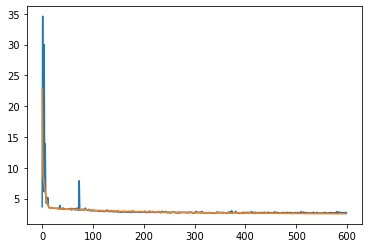

In [24]:
plt.plot(val_loss_list)
plt.plot(train_loss_list)
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

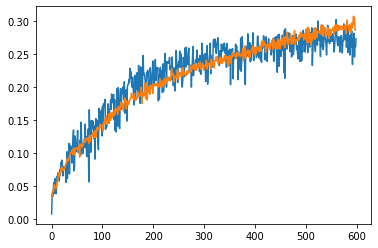

In [25]:
plt.plot(val_acc_list)
plt.plot(train_acc_list)
plt.legend

In [19]:
save_path = './test600epoch_norandomerase.pth'
torch.save(net.state_dict(),save_path)

In [20]:
net = DNet()

In [29]:
load_path = './weights_fujifilm_randomerase_600_lr_0.0002.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)


<All keys matched successfully>

In [30]:
#net = DNet()
feature_fn =nn.Sequential(*list(net.children())).cpu()
classifier_fn = torch.nn.Sequential(*(list(net.children())[-1:] + [Flatten()] + list(net.children())[-1:]))
feature_fn = feature_fn[-1][-3]

In [31]:
class Gradcam:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]])
        one_hot_output[0][target] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

image size:  (256, 256)


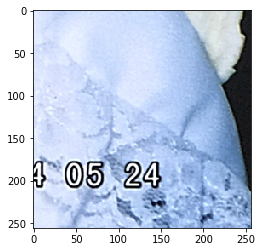

In [32]:
#テスト用画像のロード
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    #transforms.RandomErasing()
])

test_image = Image.open("./input/test_images/test_0023.png")
test_image_tensor = (transform((test_image))).unsqueeze(dim=0)

image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)
image_orig_size = test_image.size

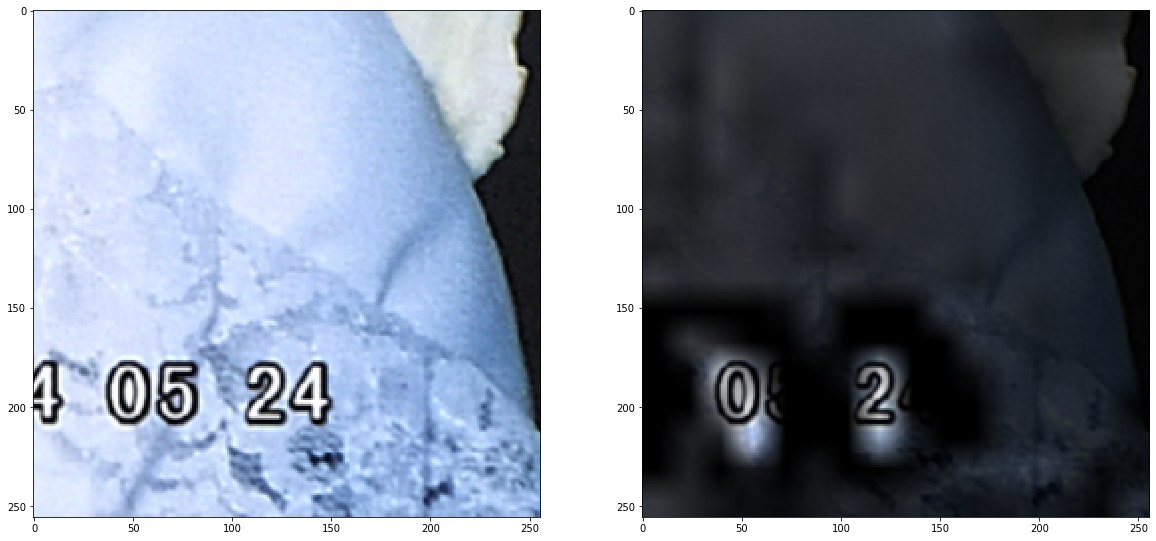

In [33]:


#gradcam = GradCAM(net, feature_fn[-1])

          
#Gradcamクラスのインスタンス化
grad_cam = Gradcam(model = net.to('cpu'), feature_layer = feature_fn)

#テスト画像を入力してアウトプット（予測クラス）を得る
model_output = grad_cam.forward(test_image_tensor)
target = model_output.argmax(0).item()

#アウトプットとターゲットから逆伝播の計算を行う
#アウトプットを出すにあたって寄与したものを見ている？
grad_cam.backward_on_target(model_output, target)

import numpy as np
# Get feature gradient(hookしていたものを取得)
feature_grad = grad_cam.feature_grad.data.numpy()[0]
# Get weights from gradient(hookしていたものを取得)
weights = np.mean(feature_grad, axis=(1, 2))  # Take averages for each gradient
# Get features outputs(mapを得る)
feature_map = grad_cam.feature_map.data.numpy()
grad_cam.clear_hook()

# CAM画像の作成
cam = np.sum((weights * feature_map.T), axis=2).T
cam = np.maximum(cam, 0)  # apply ReLU to cam

VISUALIZE_SIZE = (224, 224)
import cv2
cam = cv2.resize(cam, VISUALIZE_SIZE)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # 0-1で正規化
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize

activation_heatmap = np.expand_dims(cam, axis=0).transpose(1,2,0)
org_img = np.asarray(test_image.resize(VISUALIZE_SIZE))
img_with_heatmap = np.multiply(np.float32(activation_heatmap), np.float32(org_img))
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
org_img = cv2.resize(org_img, image_orig_size)


import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(org_img)
plt.subplot(1,2,2)
plt.imshow(cv2.resize(np.uint8(255 * img_with_heatmap), image_orig_size))
plt.show()